In [2]:
import pandas as pd
import requests as req
import numpy as np

# Scrapping packages
from bs4 import BeautifulSoup as bs

# Google Trends API connection
# documentation -> https://pypi.org/project/pytrends/#api-methods
from pytrends.request import TrendReq
pytrends = TrendReq()

# Statistics + plotting
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


##### CLEAN IT

# 1. Data from canva.com

In [7]:
# Read text file with Canva's HTML "https://www.canva.com/create-a-design"
f = open('../project-4/canva.txt', 'r')
content = f.read()

soup = bs(content, 'html.parser')
soup

<body><div class="NqU4Yg" style="z-index: 4;"><div class="_9HetvA"><div class="GddRww Eng2TQ" style="transition: transform 300ms ease-in-out 0s, opacity 300ms ease-in 0s; opacity: 0;"></div></div></div><div id="root"><div class="yIDCqA"><div class="yIDCqA"><div class="vMLlSA DEcs3Q h8ooSQ"><div class="_5o3nPw xmZGLQ WYbhjg"><header class="_-VxbfQ"><div class="_0TczQQ"><div class="IDdBMg _0ukAdA"><a class="ovm4pQ" draggable="false" href="/"><div class="_-pFsfA">Canva home</div><div class="S4786w"><svg height="60" viewbox="0 0 70 70" width="60" xmlns="http://www.w3.org/2000/svg"><g fill="none" fill-rule="evenodd"><path d="M35 0C15.67 0 0 15.67 0 35s15.67 35 35 35 35-15.67 35-35S54.33 0 35 0z" fill="#00C4CC"></path><path d="M58.4 36c-.4 0-1.1-.1-1.1-.5s.9-.2.8-1.1c-.1-.6-.7-.8-1.3-.8-2 0-3.3 2.6-3 4.7.1.8.5 1.7 1.3 1.7.6 0 1.5-.9 1.9-2.2.2-.8 1-1.5 1.7-1.5.3 0 .5.1.6.5 0 .2 0 .6-.4 1.9-.5.9-.5 1.4-.4 1.8.1.8.5 1.4.9 1.7.1.1.2.3.2.3 0 .2-.1.4-.4.4-.1 0-.2 0-.3-.1-1.5-.6-2.1-1.6-2.3-2.6-.6.

In [18]:
soup.find('span', {'class':'s-xOCQ'})

<span class="s-xOCQ">Video</span>

In [14]:
# Create a list to store subcategories scrapped from 'https://www.canva.com/create-a-design'
cat = []
sub_cat = []

# Iterate and append to cat:
cat_list = soup.find_all('span', {'class':'s-xOCQ'})

cat = [c.text for c in cat_list]
    
# Iterate and append to sub_cat:
subCat_list = soup.find_all('p', {'class':'MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q'})
for c in subCat_list:
    sub_cat.append(c.text)

In [15]:
# Explore results
print(cat)
print(sub_cat)

['Video', 'Social Media', 'Documents', 'Personal', 'Education', 'Marketing', 'Events', 'Ads']
['Animated Social Media', 'Video', 'Facebook Video', 'Social Feed Video Ad', 'Pinterest Video Pin', 'In-Stream Video Ad', 'Animated Social Media', 'Facebook Video', 'Instagram Post', 'Instagram Story', 'Facebook Post', 'Facebook Story', 'Presentation', 'A4 Document', 'Letter', 'Letterhead', 'Resume', 'Presentation (4:3)', 'Card', 'Birthday Card', 'Photo Collage', 'Photo Book', 'Calendar', 'Planner', 'Yearbook', 'Class Schedule', 'Worksheet', 'Lesson Plan', 'Report Card', 'Bookmark', 'Logo', 'Poster', 'Flyer', 'Business Card', 'Infographic', 'Brochure', 'Invitation', 'Birthday Invitation', 'Wedding Invitation (Portrait)', 'Announcement', 'Programme', 'Event Programme', 'Facebook Ad', 'Instagram Ad', 'Large Rectangle Ad', 'Leaderboard Ad', 'Wide Skyscraper Ad', 'Medium Rectangle Ad']


In [5]:
# Create DataFrame where we will combine the subcategory info
tem = pd.DataFrame(columns=['Subcategory', 'Category'])

## MVP version
categories = {'Documents': ['Presentation', 'A4 Document', 'Letter', 'Letterhead', 'Resume', 'Presentation (4:3)', 'Report', 'Daily Report', 'Memo', 'Invoice']}

documents = pd.DataFrame(columns=['Subcategory', 'Category'])
documents['Subcategory'] = ['Presentation', 'A4 Document', 'Letter', 'Letterhead', 'Resume', 'Presentation (4:3)', 'Report', 'Daily Report', 'Memo', 'Invoice']
documents['Category'] = 'Documents'
documents

# Create a dictionary with the cat - sub_cat relation
### (BONUS) scrape it

# Populate Subcategory Series
#tem['Subcategory'] = list(set(sub_cat))

#tem[tem['Subcategory'] in categories.values()]

,Subcategory,Category
0,Presentation,Documents
1,A4 Document,Documents
2,Letter,Documents
3,Letterhead,Documents
4,Resume,Documents
5,Presentation (4:3),Documents
6,Report,Documents
7,Daily Report,Documents
8,Memo,Documents
9,Invoice,Documents


# 2. Google trends

In [6]:
# API call to Google Trends
def get_trend(keyword:str):
    
        # Build the payload
        kw_list = [keyword]
        pytrends.build_payload(kw_list, cat=0, timeframe=f'today 5-y', geo='', gprop='') # 5 years | globally
        df = pytrends.interest_over_time().reset_index()
        df = df.rename(columns={'date': 'Date', keyword: 'Trend'})
        return df
    
# .drop('isPartial', axis=1, inplace=True)

In [7]:
# Dictionary with keyword that is being evaluated per each subcategory 'sub'
sub_dic = {'presentation': 'presentation template',
           'a_4': 'A4 template',
           'letter': 'letter template' ,
           'letterhead': 'letterhead template',
           'resume': 'resume template',
           'presentation_4_3': '4:3 template',
           'report': 'report template',
           'daily_report': 'daily report template',
           'memo': 'memo template',
           'invoice': 'invoice template'}

# Create a list with the keys
clean_list = sub_dic.keys()

for category in sub_dic:
    sub_dic[category] = get_trend(sub_dic[category])

In [8]:
# Check the output
sub_dic['a_4'].head()

,Date,Trend,isPartial
0,2015-07-12,76,False
1,2015-07-19,66,False
2,2015-07-26,46,False
3,2015-08-02,58,False
4,2015-08-09,54,False


In [9]:
# LEGACY CODE
#presentation = get_trend(clean_dic['presentation'])
#a4 = get_trend(clean_dic['a4'])
#letter = get_trend(clean_dic['letter'])
#letterhead = get_trend(clean_dic['letterhead'])
#resume = get_trend(clean_dic['resume'])
#presentation_4_3 = get_trend(clean_dic['presentation_4_3'])
#report = get_trend(clean_dic['report'])
#daily_report = get_trend(clean_dic['daily_report'])
#memo = get_trend(clean_dic['memo'])
#invoice = get_trend(clean_dic['invoice'])

# 3. Key word planner

Importing the weekly search range

In [10]:
# Average monthly search volume from 'https://ads.google.com/aw/keywordplanner/ideas/new?ocid=288160316&euid=220210981&__u=7630327869&uscid=288160316&__c=9136488284&authuser=0&__e=2685651001&sf=barebones&subid=de-de-et-g-aw-a-tools-kwp_bb-awhp_xin1%21o2'
search_vol = {'presentation':{'min': 10000, 'max': 100000}, 
              'a_4': {'min': 10, 'max': 100}, 
              'letter': {'min': 10000, 'max': 100000}, 
              'letterhead': {'min': 10000, 'max': 100000},
              'resume': {'min': 100000, 'max': 1000000},
              'presentation_4_3': {'min': 10, 'max': 100},
              'report': {'min': 10000, 'max': 100000},
              'daily_report': {'min': 1000, 'max': 100000},
              'memo': {'min': 10000, 'max': 100000},
              'invoice': {'min': 100000, 'max': 1000000}}
                
# Populate the DataFrames with seach volumes
for sub in sub_dic:
    
    # Create new columns
    sub_dic[sub] = (sub_dic[sub]
           .assign(Min=round((search_vol[sub]['min']*12) / 52))
           .assign(Max=round((search_vol[sub]['max']*12) / 52))
           .assign(Average=round((((search_vol[sub]['min'] * 12) / 52) + ((search_vol[sub]['max']*12)/52)) / 2))
               )
    
    # Generate new column with random per week
    sub_dic[sub]['Random'] = [np.random.randint(sub_dic[sub]['Min'].min(), sub_dic[sub]['Max'].max()) for row in range(len(sub_dic[sub]))]
    
    # Create a colum trend * mean
    sub_dic[sub]['Search Vol'] = round((sub_dic[sub]['Trend'] / 100) * sub_dic[sub]['Average'], 0)

In [11]:
# Check the output
sub_dic['a_4'].head()

,Date,Trend,isPartial,Min,Max,Average,Random,Search Vol
0,2015-07-12,76,False,2,23,13,12,10.0
1,2015-07-19,66,False,2,23,13,19,9.0
2,2015-07-26,46,False,2,23,13,14,6.0
3,2015-08-02,58,False,2,23,13,19,8.0
4,2015-08-09,54,False,2,23,13,11,7.0


In [12]:
## BONUS - Integrate with the API

## Templates that Canva is offering

Count the # of templates that Canva is offering in its website

In [13]:
templates_vol = {'presentation': 1000, 
                 'a_4': 3500, 
                 'letter': 886, 
                 'letterhead': 886,
                 'resume': 1483,
                 'presentation_4_3': 1146,
                 'report': 1273,
                 'daily_report': 98,
                 'memo': 426,
                 'invoice': 167}

for sub in sub_dic:

    # Assign to DataFrames
    sub_dic[sub]['Number of templates'] = templates_vol[sub]

In [14]:
sub_dic['a_4'].head()

,Date,Trend,isPartial,Min,Max,Average,Random,Search Vol,Number of templates
0,2015-07-12,76,False,2,23,13,12,10.0,3500
1,2015-07-19,66,False,2,23,13,19,9.0,3500
2,2015-07-26,46,False,2,23,13,14,6.0,3500
3,2015-08-02,58,False,2,23,13,19,8.0,3500
4,2015-08-09,54,False,2,23,13,11,7.0,3500


## Check Data types + final cleaning

In [15]:
sub_dic['a_4'].dtypes

Date                   datetime64[ns]
Trend                           int64
isPartial                        bool
Min                             int64
Max                             int64
Average                         int64
Random                          int64
Search Vol                    float64
Number of templates             int64
dtype: object

# Basic plotting

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

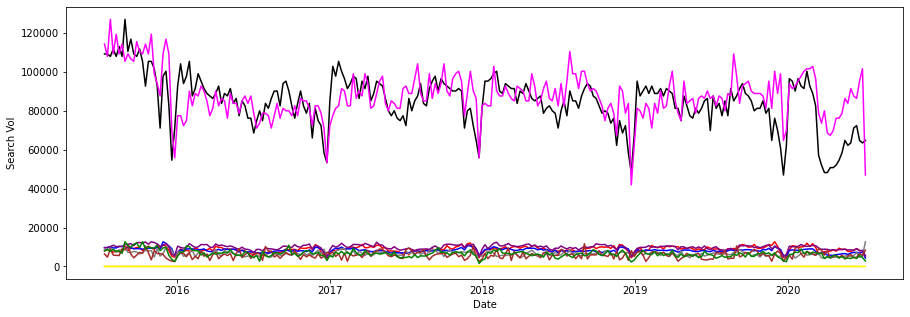

In [17]:
# Volume of searchs
sub_colors = {'presentation': 'red', 
              'a_4': 'orange', 
              'letter': 'blue', 
              'letterhead': 'grey',
              'resume': 'black',
              'presentation_4_3': 'yellow',
              'report': 'purple',
              'daily_report': 'brown',
              'memo': 'green',
              'invoice': 'magenta'}

plt.figure(figsize=(15,5))

for sub, colr in zip(sub_dic, sub_colors.values()):
    
    # Create a graph with the volume of searches
    ax = sns.lineplot(data=sub_dic[sub], 
                  x='Date', 
                  y='Search Vol',
                  color=colr)
    
# [Bonus] --> Adding legen with sub category name

Resume and Invoice sub-categories have much more search vol than the rest. For the sake of the analysis, could be interesting to add those sub-categories with less than 10.000 monthly visits.

In [18]:
# Same plot with subcategories with less than 10.000 monthly searches on average
sub_dic_gp = {'Under 10k': pd.DataFrame(columns=['Date', 'Search Vol']),
              'Under 100k': pd.DataFrame(columns=['Date', 'Search Vol'])}

# Aggregate DataFrames by groups depending on Search Vol.
for sub, colr in zip(sub_dic, sub_colors.values()):
    
    # Subcategories with an avge of less than 10k monthly seaches
    if (sub_dic[sub]['Search Vol'].mean() * 52) / 12 < 10000:
        sub_dic_gp['Under 10k'] = pd.concat([sub_dic_gp['Under 10k'], sub_dic[sub]])
    
    # Subcategories with an avge of less than 10k monthly seaches
    elif ((sub_dic[sub]['Search Vol'].mean() * 52) / 12 < 100000) & ((sub_dic[sub]['Search Vol'].mean() * 52) / 12 > 10000):
        sub_dic_gp['Under 100k'] = pd.concat([sub_dic_gp['Under 100k'], sub_dic[sub]])
    
    # The rest will be analysed individually
    else:
        sub_dic_gp[sub] = sub_dic[sub]

# Grouping by day and summing 'Seatch Vol.'
sub_dic_gp['Under 10k'] = sub_dic_gp['Under 10k'].groupby('Date', as_index=False).agg('sum')
sub_dic_gp['Under 100k'] = sub_dic_gp['Under 100k'].groupby('Date', as_index=False).agg('sum')

In [19]:
# Checking the results
sub_dic_gp['Under 100k'].head()

,Date,Search Vol,Trend,Min,Max,Average,Random,Number of templates
0,2015-07-12,50198.0,400.0,11771.0,138462.0,75114.0,74710.0,4569.0
1,2015-07-19,49835.0,396.0,11771.0,138462.0,75114.0,66897.0,4569.0
2,2015-07-26,54422.0,435.0,11771.0,138462.0,75114.0,80773.0,4569.0
3,2015-08-02,51010.0,406.0,11771.0,138462.0,75114.0,77443.0,4569.0
4,2015-08-09,48228.0,384.0,11771.0,138462.0,75114.0,62373.0,4569.0


Now we have a dictionary with a DataFrame that aggregates the subcategories with less that 10k monthly searches as 'Under 10k', a DataFrame that aggregates the subcategories with less that 100k monthly searches as 'Under 100k' and individual DataFrames for those subcategories with more than 100k monthly searches.

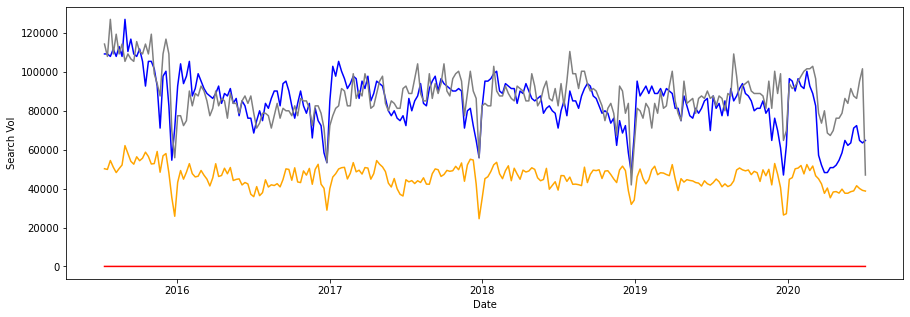

In [20]:
# Plot 
plt.figure(figsize=(15,5))

for sub, colr in zip(sub_dic_gp, sub_colors.values()):
    
    # Create a graph with the volume of searches
    ax = sns.lineplot(data=sub_dic_gp[sub], 
                  x='Date', 
                  y='Search Vol',
                  color=colr)
    
## [BONUS] - Add legends

It would be useful to list the subcategories in each category.

In [21]:
# [BONUS] - List a summary with the categories in each bin. [Under 10k] | [Under 100k] | [Over 100k]

### Find 'Search Vol' trend

In [22]:
# Combine all searches and find the trend. 
# We will be able to compare each sub_category with the overall trend
# Statistical analysis

In [23]:
sub_dic_gp['Total'] = pd.DataFrame(columns=['Date', 'Search Vol'])

# Concat all DataFrames into one
for sub in sub_dic:
    sub_dic_gp['Total'] = pd.concat([sub_dic_gp['Total'], sub_dic[sub]])

sub_dic_gp['Total'] = sub_dic_gp['Total'].groupby('Date', as_index=False).agg('sum')

#### Calculate the fitted line

In [87]:
# Create a constant
sub_dic_gp['Total'] = sm.add_constant(sub_dic_gp['Total'])
sub_dic_gp['Total'] = sub_dic_gp['Total'].assign(t=range(1, len(sub_dic_gp['Total']) + 1))
# sub_dic_gp['Total'] = sub_dic_gp['Total'].assign(t2=range(1, (len(sub_dic_gp['Total']) + 1)**2))

# Run OLS
X = sub_dic_gp['Total'][["const", "t"]]
y = sub_dic_gp['Total']["Search Vol"]

lin_reg = sm.OLS(y, X)
results_total = lin_reg.fit()

results_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Search Vol   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     43.92
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           1.98e-10
Time:                        17:43:16   Log-Likelihood:                -3014.5
No. Observations:                 261   AIC:                             6033.
Df Residuals:                     259   BIC:                             6040.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.364e+05   3129.299     75.533      0.000     2.3e+05    2.43e+05
t           -137.2248     20.707     -6.627      0.000    -178.001     -96.449
==============================================================================
Omnibus:                       26.434   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.929
Skew:                          -0.682   Prob(JB):                     1.58e-08
Kurtosis:                       4.201   Cond. No.                         303.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

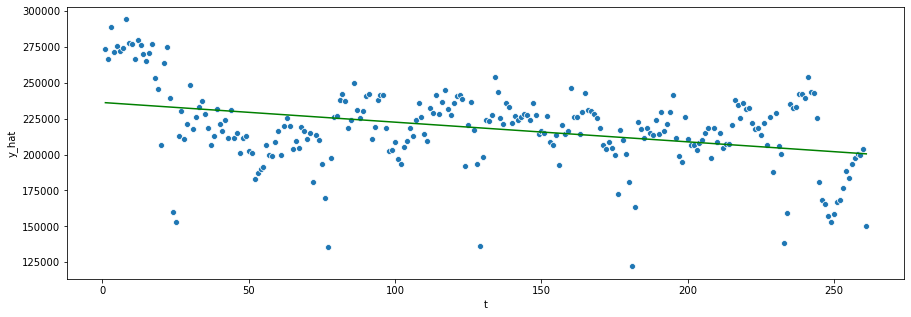

In [89]:
sub_dic_gp['Total'] = sub_dic_gp['Total'].assign(y_hat=results_total.predict(X))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=sub_dic_gp['Total'], 
                x='t', 
                y='Search Vol');

sns.lineplot(data=sub_dic_gp['Total'],
             x='t',
             y="y_hat",
             color="green");

In [ ]:
# Run OLS
lin_reg = sm.OLS(sub_dic_gp['Total']["Date"],
                 sub_dic_gp['Total'][['const', 'Search Vol']])

result = lin_reg.fit()

corr = sm.add_constant(corr)
corr.head()

# Run OLS
lin_reg = sm.OLS(corr["Search Vol (avge)"],
                 corr[["const", "Number of templates"]])

result = lin_reg.fit()

result.summary()
# result.summary()

In [ ]:
plt.figure(figsize=(15,5))
    
    # Create a graph with the total volume of searches
ax = sns.lineplot(data=sub_dic_gp['Total'], 
                  x='Date', 
                  y='Search Vol',)

ax = sns.regplot(data=sub_dic_gp['Total'], 
                  x='Date', 
                  y='Search Vol',)

In [ ]:
# Find if there is a correlation between 'Templates' that Canva is offering and 'Search Vol' 
# We will be able to do a linear regression
# Statistical analysis

### 'Search Vol' vs. # 'Template '

Is there a correlation between the Search Vol for the Keywords assigned to the category and the number of templates that Canva is offering? Is it statistically significant?

In [42]:
corr = pd.DataFrame(columns=['Sub-Category', 'Search Vol (avge)', 'Number of templates'])

corr['Sub-Category'] = sub_dic.keys()
corr['Search Vol (avge)'] = [int(sub_dic[sub]['Search Vol'].mean()) for sub in sub_dic]
corr['Number of templates'] = [int(sub_dic[sub]['Number of templates'].mean()) for sub in sub_dic]

corr

,Sub-Category,Search Vol (avge),Number of templates
0,presentation,8815,1000
1,a_4,7,3500
2,letter,8227,886
3,letterhead,6545,886
4,resume,84741,1483
5,presentation_4_3,5,1146
6,report,9888,1273
7,daily_report,5986,98
8,memo,6461,426
9,invoice,87708,167


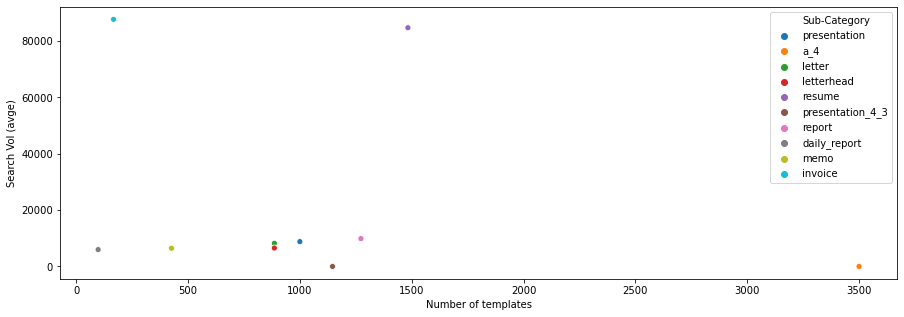

In [54]:
# Scatter plot to infere if it makes sense to calculate the fitted line
plt.figure(figsize=(15,5))
    
sns.scatterplot(data=corr, 
                x='Number of templates', 
                y='Search Vol (avge)',
                hue='Sub-Category');

In [60]:
# See if there is a correlation between the two variables
corr = sm.add_constant(corr)
corr.head()

# Run OLS
lin_reg = sm.OLS(corr["Search Vol (avge)"],
                 corr[["const", "Number of templates"]])

result = lin_reg.fit()

result.summary()

/opt/miniconda3/envs/boogie_woogie/lib/python3.8/site-packages/scipy/stats/stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Search Vol (avge)   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                 -0.080
Method:                 Least Squares   F-statistic:                    0.3322
Date:                Tue, 07 Jul 2020   Prob (F-statistic):              0.580
Time:                        15:53:53   Log-Likelihood:                -117.83
No. Observations:                  10   AIC:                             239.7
Df Residuals:                       8   BIC:                             240.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.951e+04   1.74e+04      1.696      0.128   -1.06e+04    6.96e+04
Number of templates    -7.0627     12.254     -0.576      0.580     -35.320      21.194
==============================================================================
Omnibus:                        6.690   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                3.353
Skew:                           1.416   Prob(JB):                        0.187
Kurtosis:                       3.156   Cond. No.                     2.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
corr = corr.assign(y_hat=result.predict(corr[["const", "Number of templates"]]))

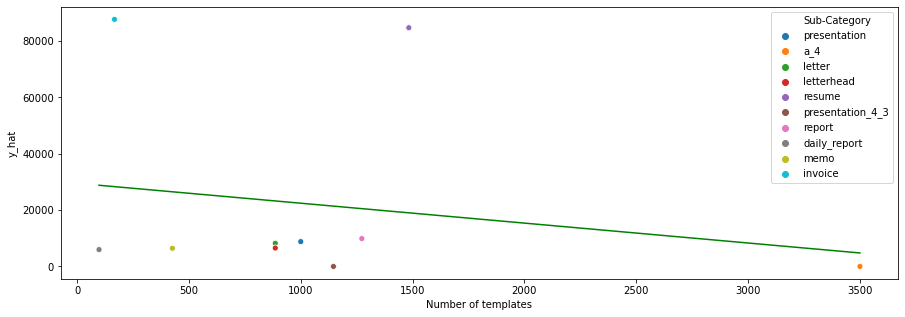

In [66]:
plt.figure(figsize=(15,5))
    
sns.scatterplot(data=corr, 
                x='Number of templates', 
                y='Search Vol (avge)',
                hue='Sub-Category');

sns.lineplot(data=corr,
             x='Number of templates',
             y="y_hat",
             color="g");

---------------------------------------------------

## Bonus

1. Try to get the data with requests. Now it is hardcoded
2. Segment the subcategories by categories


In [ ]:
pd.DataFrame(columns=["Subcategory", "Categoty"])

In [ ]:
headers = {'authority': 'www.canva.com',
'method': 'GET',
'path': '/create-a-design',
'scheme': 'https',
'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
'accept-encoding': 'gzip, deflate, br',
'accept-language': 'en-US,en;q=0.9',
'cache-control': 'max-age=0',
'cookie': '__cfduid=dac51796841329b70661ebd07a4b3a8901591811643; CDI=888a9880-c327-4479-8e8b-9ba1da774a1a; CL=es-ES; ajs_group_id=null; ajs_anonymous_id=%22c1a4a653-107a-4341-b28e-dcdaf8b30169%22; _gcl_au=1.1.1259495208.1591811645; _ga=GA1.2.1022411617.1591811645; ab.storage.deviceId.320f7332-8571-45d7-b342-c54192dae547=%7B%22g%22%3A%223abc1a29-8121-d7ca-340a-f31fe27706a3%22%2C%22c%22%3A1591811645287%2C%22l%22%3A1591811645287%7D; _fbp=fb.1.1591811645414.41094145; CB=BADs5VlD2Bg; CS=1; ajs_user_id=%22UADs5dLCEjE%22; ab.storage.userId.320f7332-8571-45d7-b342-c54192dae547=%7B%22g%22%3A%22UADs5dLCEjE%22%2C%22c%22%3A1591811662791%2C%22l%22%3A1591811662791%7D; __stripe_mid=c81db500-bdf2-487a-a5ad-75ae9d22e99b; campaignTracker=CareersPage; _gid=GA1.2.1025166503.1593962736; CAZ=boxflnJsf51aH3f71XiopuK3CrO8cuyuw5GrquQTD0tB_GJG-s5RmTzX-G-dXfiWHRCZV2y7VciCP03NELbLJ5tNINCVqYopTdPp0n1kjTsxTykxlMMcONC6yL8Y-FDGr_yr6PwliRtGM8McXtxwoy1TY6qBhoKyCphBLIBg2ZpjJl5yTfHNdwnStMjDlJ3luXbDPF02J0GO2pQyiKvgMEIGohhRP54XtaKNrSHHpJtTRM9sTt1hjHgd-IUrOPEYDT0pS96LxcX1wRC_LrECNorvyQy6aQsWTstopMKSvJ6ZnbLh5Yu_5gWDcAUa2n1TkZI1zqHu_F_hQhTmOAH-60UskCnfkFHNa2UPQTkgbET9KsrE2cYhKWV3xrlh11zJSXjSK5KeRyurWLo6gkgcbxyOJhSs-eep2K7J4WC1MXUqUW2czm-NS4PZ8FTK-iEpBPpLp9vyMuSIFBR1q2pNKXYwZZRLhsmXAqYCvBsxUq-YdsJnftP06QLiyTJv_myWKX4n35ye1qsiuvQ9slYH6CrBfptmNSUFjK3ShZzrjCRiM2D4S9IfuEHizzp-C5cw8peDgnmIozjPZ4iaY-Nj0hDqvm1NNjb7KXarqVcH3B0xWoVKTP8ViM5hHDzvkHYx32EEr6vzsNQCowgbU09xZRHBkexnW-TRF2yvzAGrok4_SIrDZNXJgpFmC1kIj4bpzjtWgP12DVlh5Ozg-tXEtgTloa2SL0mSHchEG3N0FKcrc-3w; CID=_FTzF4vDbEzgzTdotlrRYpAVj_CG6qR2E5VkUbDA7N18UAf-k8DFGqh9ph_dViSM4aeyHv7RoKZ_MV12GlLN6znSv0OJoIst4JvST3qqAnKSVf72; CUI=RAVzK9FjV4qqVyq91U-AAcoMQOJY2LUfEowvOApAtSrMP9gIZpgZhHuTSb6HcZB_5HKR3w; _uetsid=76b9bd64-a296-63f2-c087-1570adb8bf21; _uetvid=233327d4-113a-e5a7-fd6f-b7cabb771c47; ab.storage.sessionId.320f7332-8571-45d7-b342-c54192dae547=%7B%22g%22%3A%22939a268b-0650-81f9-ceb0-7ab6c1e10c12%22%2C%22e%22%3A1594023258512%2C%22c%22%3A1594020164402%2C%22l%22%3A1594021458512%7D',
'sec-fetch-dest': 'document',
'sec-fetch-mode': 'navigate',
'sec-fetch-site': 'none',
'sec-fetch-user': '?1',
'upgrade-insecure-requests': '1',
'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36',
'token': '...'}


In [ ]:
soup.select('div', {'id':'genre-video'})

# soup2 = bs(subset, 'html.parser')

# soup2.find_all('p', {'class':'MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q'})

#for cat in subCat_list:
#    sub_cat.append(cat.text)

#        for card in soup.select("div.result-card__contents"):
 #           title = card.findChild("h3", recursive=False)
  #          company = card.findChild("h4", recursive=False)
   #         location = card.findChild("span", attrs={"class": "job-result-card__location"}, recursive=True)
    #        titles.append(title.string)
     #       companies.append(company.string)
      #      locations.append(location.string)

In [ ]:
#video = soup.find_all('div', {'class': 'K1bdNw ElK36A eGNjaw RTlscw'})

#[category.find('p', {'class': 'MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q'}).text for category in video]
    
#video_list = []
#for vid_cat in video:
#    video_list.append(vid_cat.text)
    
#video_list 